In [29]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import math
import time
import os.path
import matplotlib
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics         import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy                   import interp
from IPython.core.pylabtools import figsize

%matplotlib inline
matplotlib.style.use('ggplot')

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 27 ms


In [3]:
train = pd.read_csv('input/train.csv')
test  = pd.read_csv('input/test.csv')

train01 = train.copy().sample(frac=0.01, replace=False)
train   = train01.copy()

test01 = test.copy().sample(frac=0.01, replace=False)
test   = test01.copy()


time: 3min 9s


In [8]:
train.describe()

,ip,app,device,os,channel,is_attributed
count,1.849039e+06,1.849039e+06,1.849039e+06,1.849039e+06,1.849039e+06,1.849039e+06
mean,9.087785e+04,1.199862e+01,2.177848e+01,2.267727e+01,2.687131e+02,2.410982e-03
std,6.953677e+04,1.475545e+01,2.596613e+02,5.530568e+01,1.296250e+02,4.904254e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.024100e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.450000e+02,0.000000e+00
50%,7.966600e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00
75%,1.182290e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00
max,3.647760e+05,7.340000e+02,4.021000e+03,8.830000e+02,4.980000e+02,1.000000e+00


time: 741 ms


In [7]:
test.describe()

,click_id,ip,app,device,os,channel
count,1.879050e+05,187905.000000,187905.000000,187905.000000,187905.000000,187905.000000
mean,9.399677e+06,63017.512940,12.228456,1.686262,18.739406,264.878279
std,5.426953e+06,36881.453732,11.817347,25.187222,11.397211,135.463927
min,1.450000e+02,5.000000,0.000000,0.000000,0.000000,3.000000
25%,4.695343e+06,31542.000000,3.000000,1.000000,13.000000,135.000000
50%,9.398641e+06,63932.000000,12.000000,1.000000,18.000000,236.000000
75%,1.410390e+07,95294.000000,18.000000,1.000000,19.000000,401.000000
max,1.879038e+07,126410.000000,379.000000,2859.000000,560.000000,498.000000


time: 102 ms


In [16]:
def transforms(df):
    df['hour'] = pd.to_datetime(df.click_time).dt.hour.astype('uint8')
    df['day']  = pd.to_datetime(df.click_time).dt.day.astype('uint8')
    
    X = df.as_matrix(columns=['ip', 'app', 'device', 'os', 'channel', 'hour', 'day'])
    
    return X

train_X = transforms(train)
test_X  = transforms(test)

time: 2.14 s


In [23]:
import lightgbm as lgb
                    
                                      
def trainLGBM(train,X,targetFeature):

    y = train.loc[:,targetFeature].values.ravel()

    print("X:{0}, y:{1}".format(np.shape(X),np.shape(y)))
    print("Training on {0}".format(targetFeature))

    print("Initializing classifier. . .")
    gbm = lgb.LGBMClassifier(objective='binary',
                             metric='binary_logloss',
                             learning_rate=0.1,
                             #n_estimators=50,
                             sub_feature=.514492,
                             num_leaves=255,
                             max_depth=7,
                             min_data=32,
                             verbosity=0,
                             bagging_fraction=0.85,
                             lambda_l1=.018953,
                             lambda_l2=.05242,
                             bagging_freq=5,
                             nthread=8,
                             silent=True)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    cv = StratifiedKFold(n_splits=2)
    for train, test in cv.split(X, y):
        gbm.fit(X[train,:], y[train],
                eval_set=[(X[test,:], y[test])],
                eval_metric='binary_logloss',
                early_stopping_rounds=3)
        
        y_proba = gbm.predict_proba(X[test,:], num_iteration=gbm.best_iteration_)
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], y_proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        i += 1

    
    return np.mean(aucs),fpr,tpr, len(y)



score, fpr, tpr, sampleSize = trainLGBM(train=train, X=train_X, targetFeature='is_attributed')




X:(1849039, 7), y:(1849039,)
Training on is_attributed
Initializing classifier. . .
[1]	valid_0's binary_logloss: 0.598818
Training until validation scores don't improve for 3 rounds.
[2]	valid_0's binary_logloss: 0.52157
[3]	valid_0's binary_logloss: 0.457282
[4]	valid_0's binary_logloss: 0.402962
[5]	valid_0's binary_logloss: 0.356435
[6]	valid_0's binary_logloss: 0.316361
[7]	valid_0's binary_logloss: 0.281619
[8]	valid_0's binary_logloss: 0.251351
[9]	valid_0's binary_logloss: 0.224816
[10]	valid_0's binary_logloss: 0.201587
[11]	valid_0's binary_logloss: 0.180985
[12]	valid_0's binary_logloss: 0.162782
[13]	valid_0's binary_logloss: 0.146648
[14]	valid_0's binary_logloss: 0.132368
[15]	valid_0's binary_logloss: 0.119664
[16]	valid_0's binary_logloss: 0.108373
[17]	valid_0's binary_logloss: 0.098142
[18]	valid_0's binary_logloss: 0.0888986
[19]	valid_0's binary_logloss: 0.0808244
[20]	valid_0's binary_logloss: 0.0734896
[21]	valid_0's binary_logloss: 0.0668579
[22]	valid_0's binary

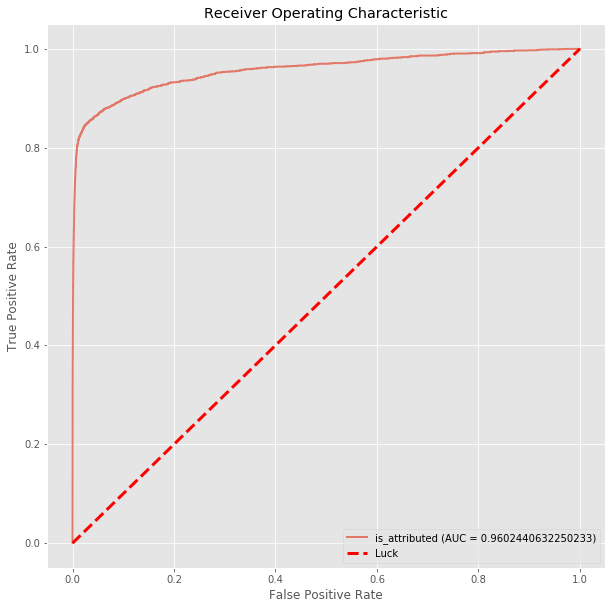

time: 533 ms


In [30]:
                                
def graph(score, fpr, tpr):


    figsize(10,10)
    scores  = []
    plt.plot(fpr,tpr, lw=2, alpha=.7, 
             label="{0} (AUC = {1})".format('is_attributed', score))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='r', label='Luck', alpha=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    name = 'ROC_{0}.png'.format(datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S"))
    plt.savefig(name)
    plt.show()
    
    return

graph(score,fpr,tpr)